# Stock-level datasets 

In [1]:
import pandas as pd
import yfinance as yf
from skfin.plot import *
from tqdm.auto import tqdm

## Returns data 

### Scikit-learn returns

Main issue: very limited information on how the returns were constructed. 

In [2]:
from skfin.dataset_mappings import symbol_dict
from skfin.datasets import load_sklearn_stock_returns

clip = lambda x: x.T.clip(lower=x.quantile(q=0.01, axis=0), upper=x.quantile(0.99, axis=0), axis=0).T
rescale = lambda x: x.div(x.std())

In [3]:
ret = load_sklearn_stock_returns(cache_dir="data")/100
ret_clip = ret.pipe(clip)

INFO:skfin.datasets:logging from cache directory: data/sklearn_returns.parquet


### Yahoo finance returns

Main issue: survival bias because the deslisted firms are no longer available in the past.

In [4]:
symbol_dict

{'TOT': 'Total',
 'XOM': 'Exxon',
 'CVX': 'Chevron',
 'COP': 'ConocoPhillips',
 'VLO': 'Valero Energy',
 'MSFT': 'Microsoft',
 'IBM': 'IBM',
 'TWX': 'Time Warner',
 'CMCSA': 'Comcast',
 'CVC': 'Cablevision',
 'YHOO': 'Yahoo',
 'DELL': 'Dell',
 'HPQ': 'HP',
 'AMZN': 'Amazon',
 'TM': 'Toyota',
 'CAJ': 'Canon',
 'SNE': 'Sony',
 'F': 'Ford',
 'HMC': 'Honda',
 'NAV': 'Navistar',
 'NOC': 'Northrop Grumman',
 'BA': 'Boeing',
 'KO': 'Coca Cola',
 'MMM': '3M',
 'MCD': "McDonald's",
 'PEP': 'Pepsi',
 'K': 'Kellogg',
 'UN': 'Unilever',
 'MAR': 'Marriott',
 'PG': 'Procter Gamble',
 'CL': 'Colgate-Palmolive',
 'GE': 'General Electrics',
 'WFC': 'Wells Fargo',
 'JPM': 'JPMorgan Chase',
 'AIG': 'AIG',
 'AXP': 'American express',
 'BAC': 'Bank of America',
 'GS': 'Goldman Sachs',
 'AAPL': 'Apple',
 'SAP': 'SAP',
 'CSCO': 'Cisco',
 'TXN': 'Texas Instruments',
 'XRX': 'Xerox',
 'WMT': 'Wal-Mart',
 'HD': 'Home Depot',
 'GSK': 'GlaxoSmithKline',
 'PFE': 'Pfizer',
 'SNY': 'Sanofi-Aventis',
 'NVS': 'Novarti

In [5]:
tickers = list(symbol_dict.keys())
start, end = ret.index[0].strftime("%Y-%m-%d"), ret.index[-1].strftime("%Y-%m-%d")

In [6]:
%time
data = yf.download(tickers, start=start, end=end)
data = data.dropna(how="all", axis=1)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10.5 µs
[*********************100%***********************]  56 of 56 completed

9 Failed downloads:
- NAV: No timezone found, symbol may be delisted
- CAJ: No timezone found, symbol may be delisted
- SNE: No timezone found, symbol may be delisted
- TOT: No timezone found, symbol may be delisted
- YHOO: No timezone found, symbol may be delisted
- RTN: No timezone found, symbol may be delisted
- UN: No timezone found, symbol may be delisted
- CVC: No data found for this date range, symbol may be delisted
- DELL: Data doesn't exist for startDate = 1041570000, endDate = 1199077200


In [7]:
tickers_ = data.columns.get_level_values(1).unique()
dividends = {}
for ticker in tqdm(tickers_):
    stock = yf.Ticker(ticker)
    div = stock.dividends[start:end]
    dividends[ticker] = div

div = (
    pd.concat(dividends, axis=1)
    .pipe(lambda x: x.set_index(x.index.tz_localize(None)))
    .reindex_like(data["Close"])
    .fillna(0)
    .div(data["Close"])
)

  0%|          | 0/47 [00:00<?, ?it/s]

## Survivingship bias 

In [8]:
cols = ['CAJ', 'SNE', 'UN', 'NAV', 'TOT', 'RTN', 'DELL', 'YHOO', 'CVC']
{c: symbol_dict[c] for c in cols}

{'CAJ': 'Canon',
 'SNE': 'Sony',
 'UN': 'Unilever',
 'NAV': 'Navistar',
 'TOT': 'Total',
 'RTN': 'Raytheon',
 'DELL': 'Dell',
 'YHOO': 'Yahoo',
 'CVC': 'Cablevision'}

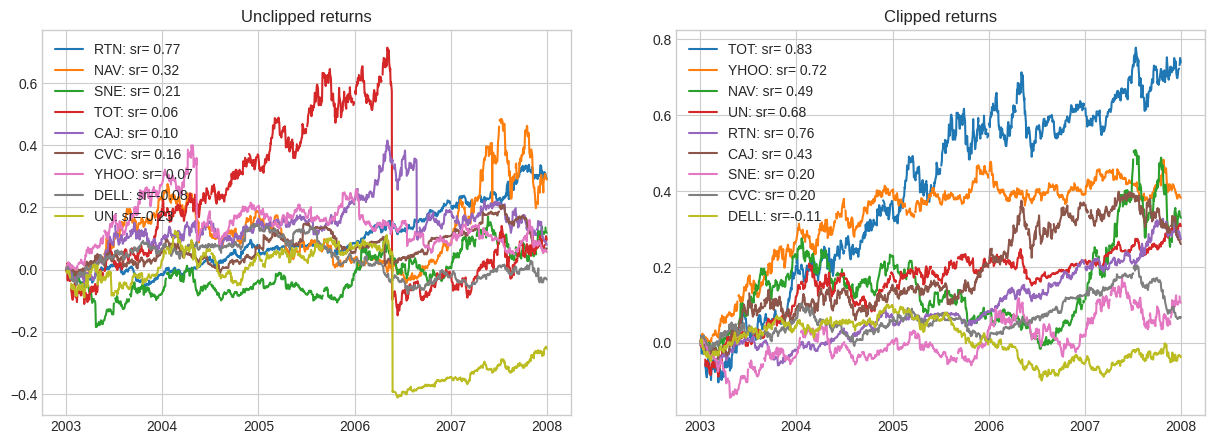

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
line(ret[cols], cumsum=True, ax=ax[0], title='Unclipped returns', loc='best')
line(ret_clip[cols], cumsum=True, ax=ax[1], title='Clipped returns', loc='best')

### Dirty data and jumps 

Total returns are defined as: 

$$ total\_returns_t = \frac{price_t + dividend_t - price_{t-1}}{price_{t-1}}.$$ 

Adjustments are necessary when there are stock splits (or reverse splits) that alter the number of shares outstanding and the nominal price per share.

In [11]:
pret = data["Adj Close"].pct_change().dropna(how="all", axis=1)
pret_close = data["Close"].pct_change().dropna(how="all", axis=1)
tret = pret.add(div)

In [12]:
rets = {
    "price returns": pret,
    "unadjusted price returns": pret_close,
    "total returns": tret,
}

In [13]:
axis = 0
pd.DataFrame({k: v.corrwith(ret, axis=axis) for k, v in rets.items()}).mean()

price returns               0.815361
unadjusted price returns    0.816734
total returns               0.810922
dtype: float64

In [14]:
axis = 0
pd.DataFrame({k: v.corrwith(ret_clip, axis=axis) for k, v in rets.items()}).mean()

price returns               0.943665
unadjusted price returns    0.945182
total returns               0.938077
dtype: float64

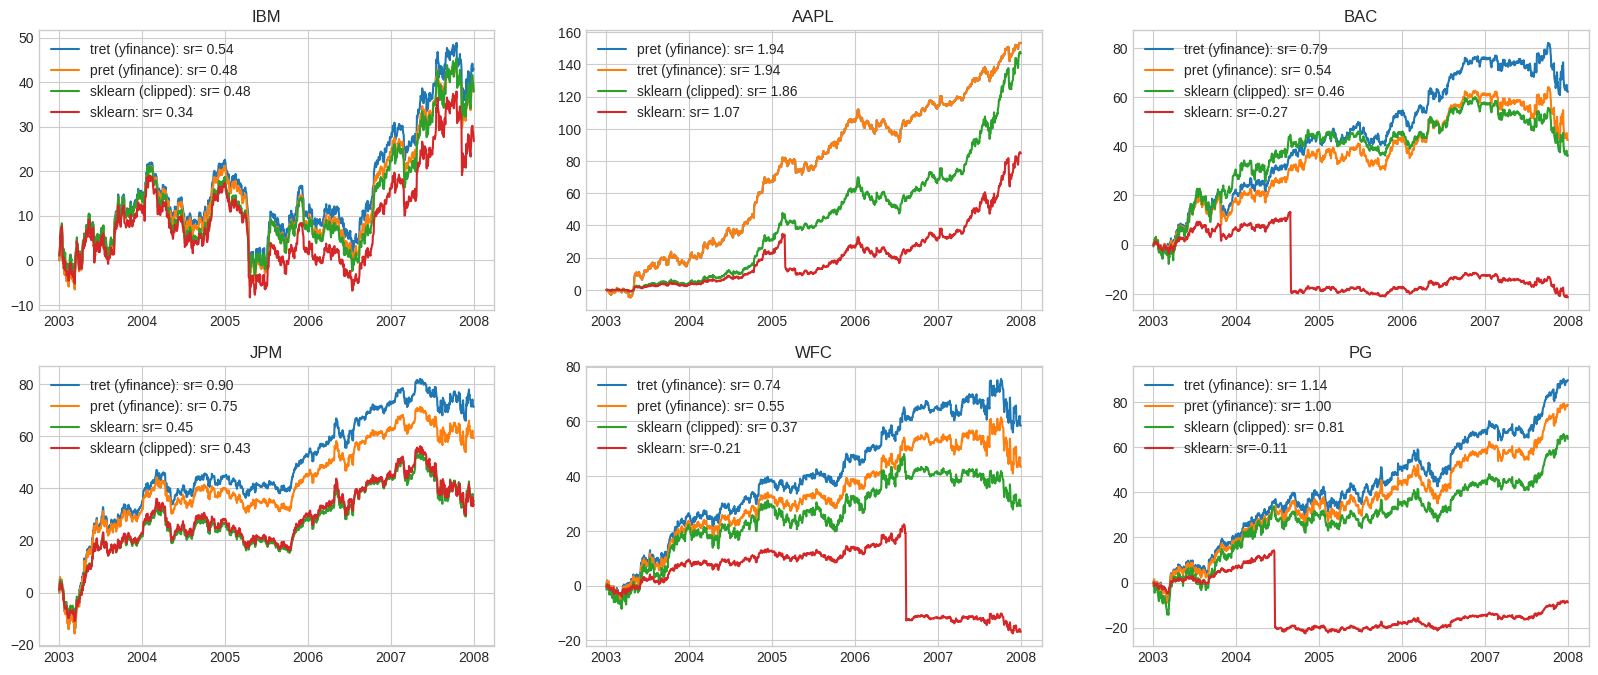

In [15]:
cols = ["IBM", "AAPL", "BAC", "JPM", "WFC", 'PG']
fig, axs = plt.subplots(2, 3, figsize=(20, 8))
axs = axs.ravel()
for i, c in enumerate(cols): 
    line(
        pd.concat(
            {
                "pret (yfinance)": pret[c],
                "tret (yfinance)": tret[c],
                "sklearn": ret[c],
                "sklearn (clipped)": ret_clip[c],
            },
            axis=1,
        )
        .fillna(0)
        .pipe(rescale),
        cumsum=True,
       title=c,
        ax=axs[i], 
        loc='best'
    )

## Matching to other datasets 

Matching company names is often a time-consuming task: below we use the package `rapidfuzz` to check the candidate matches. 

In [18]:
from skfin.datasets import load_10X_summaries, mapping_10X
df = load_10X_summaries()

INFO:skfin.datasets:logging from cache directory: data/Loughran-McDonald_10X_Summaries_1993-2021.csv


In [19]:
v = mapping_10X["CVC"]
print(v)
df.loc[lambda x: x.CoName.isin(v if isinstance(v, list) else [v])].set_index(
    "date"
).loc[ret.index[0] : ret.index[-1]].loc["2006"].iloc[:, :10]

CABLEVISION SYSTEMS CORP /NY


,CIK,FILING_DATE,ACC_NUM,CPR,FORM_TYPE,CoName,SIC,FFInd,N_Words,N_Unique_Words
date,,,,,,,,,,
2006-05-10,1053112,20060510,0001104659-06-032803,20060331,10-Q,CABLEVISION SYSTEMS CORP /NY,4841,32,38566,2327
2006-05-10,784681,20060510,0001104659-06-032803,20060331,10-Q,CABLEVISION SYSTEMS CORP /NY,4841,32,38566,2327
2006-09-21,1053112,20060921,0001104659-06-062197,20051231,10-K-A,CABLEVISION SYSTEMS CORP /NY,4841,32,92495,2946
2006-09-21,784681,20060921,0001104659-06-062197,20051231,10-K-A,CABLEVISION SYSTEMS CORP /NY,4841,32,92495,2946
2006-09-21,1053112,20060921,0001104659-06-062201,20060331,10-Q-A,CABLEVISION SYSTEMS CORP /NY,4841,32,35794,1966
2006-09-21,784681,20060921,0001104659-06-062201,20060331,10-Q-A,CABLEVISION SYSTEMS CORP /NY,4841,32,35794,1966
2006-11-08,1053112,20061108,0001104659-06-072875,20060930,10-Q,CABLEVISION SYSTEMS CORP /NY,4841,32,45265,2148
2006-11-08,784681,20061108,0001104659-06-072875,20060930,10-Q,CABLEVISION SYSTEMS CORP /NY,4841,32,45265,2148


In [17]:
CoName = list(
    df.assign(CoName=lambda x: x.CoName.str.upper())
    .groupby(["date", "CoName"])["FILING_DATE"]
    .count()
    .loc[ret.index[0] : ret.index[-1]]
    .groupby(level=1)
    .count()
    .index
)

from rapidfuzz import fuzz

pd.Series({c: fuzz.token_set_ratio("CABLEVISION", c) for c in CoName}).sort_values(
    ascending=False
).head(5)

CABLEVISION SYSTEMS CORP /NY    100.000000
PARKERVISION INC                 66.666667
CAGLES INC                       66.666667
ABLEST INC                       66.666667
LATIN TELEVISION  INC            64.516129
dtype: float64